### Implement ReAct with LangGraph - What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

In [8]:
import os
from langchain.agents import create_agent
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [2]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [3]:
retriever.invoke('What are autonomous agents?')

[Document(id='5213c92e-282a-4fdb-a6ce-8c6898c3050b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [4]:
def retriever_tool_func(query: str) -> str:
    print(" Using RAGRetriever tool ")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [5]:
retriever_tool_func("What are autonomous agents?")

 Using RAGRetriever tool 


'Boiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nFor example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning steps:\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Conten

In [10]:
from langchain_core.tools import tool

@tool("RAGRetriever")
def retriever_tool(query: str) -> str:
    """Use this tool to fetch relevant knowledge base info"""
    return retriever_tool_func(query)

print(retriever_tool.name)


RAGRetriever


In [11]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/Users/aakritinag/Documents/GitHub/Agentic-RAG/.venv/lib/python3.13/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [12]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = init_chat_model("openai:gpt-4o")

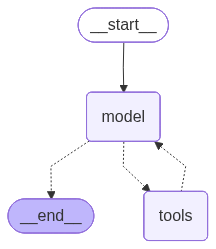

In [13]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------

tools = [retriever_tool, wiki_tool]

## create the native Langgraph react agent
react_node = create_agent(llm, tools)
react_node

In [14]:
# --------------------------
# 3. LangGraph Agent State
# --------------------------

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

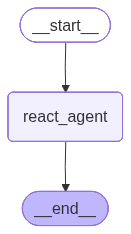

In [15]:
# --------------------------
# 4. Build LangGraph Graph
# --------------------------

builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [16]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)

 Using RAGRetriever tool 

✅ Final Answer:
 ### Agent Loop
An agent loop refers to a continuous cycle in which an autonomous agent takes actions, learns from the outcomes, and updates its decision-making policy to improve its performance. This technology is often harnessed in AI systems to enable autonomous functionality, like executing experimental tasks or solving problems without human intervention.

### Autonomous Agents (from Wikipedia)
According to Wikipedia, an autonomous agent is an artificial intelligence (AI) system capable of independently performing complex tasks. In the realm of artificial intelligence, an intelligent agent is described as an entity that perceives its environment, autonomously takes actions to achieve goals, and potentially improves performance via machine learning or knowledge acquisition. The term "agentic AI" refers to those agents proactively pursuing goals, making decisions, and carrying out actions over extended periods. These agents are designed to 

### Tool creation for RAG agents with langgraph 
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

#### ✅ Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

In [18]:
import os
from typing import Annotated, Sequence, TypedDict
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import create_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import TextLoader

In [19]:
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x1171d3230>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1171d3b60>, root_client=<openai.OpenAI object at 0x11719d1d0>, root_async_client=<openai.AsyncOpenAI object at 0x11719c410>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [20]:
def make_retriever_tool_from_text(file: str, name: str, desc: str):
    docs = TextLoader(file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    @tool(name)
    def rag_retriever(query: str) -> str:
        """Use this tool to fetch relevant knowledge base info."""
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)

    # overwrite docstring to your custom description (optional but nice)
    rag_retriever.description = desc
    return rag_retriever


In [25]:
retriever_tool = make_retriever_tool_from_text(
    "research_notes.txt",
    "RAGRetriever",
    "Use this tool to fetch relevant knowledge base info",
)
print(retriever_tool.name)


RAGRetriever


In [22]:
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool.name = "Wikipedia"
wiki_tool.description = "Use this tool to fetch general world knowledge from Wikipedia."


In [27]:
internal_tool_1=make_retriever_tool_from_text(
    "sample_docs.txt",
    "InternalTechDocs",
    "Search internal tech documents for proprietary architecture and methods."
)
internal_tool_1

StructuredTool(name='InternalTechDocs', description='Search internal tech documents for proprietary architecture and methods.', args_schema=<class 'langchain_core.utils.pydantic.InternalTechDocs'>, func=<function make_retriever_tool_from_text.<locals>.rag_retriever at 0x130dc19e0>)

In [38]:
@tool("ArxivSearch")
def arxiv_tool(query: str) -> str:
    """Use this tool to fetch recent academic papers on technical topics."""
    print("\n 🧪 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."


In [28]:
internal_tool_2 = make_retriever_tool_from_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)
internal_tool_2

StructuredTool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', args_schema=<class 'langchain_core.utils.pydantic.InternalResearchNotes'>, func=<function make_retriever_tool_from_text.<locals>.rag_retriever at 0x130d39da0>)

In [24]:
tools = [retriever_tool, wiki_tool, arxiv_tool]
for t in tools:
    print(t.name)


RAGRetriever
Wikipedia
ArxivSearch


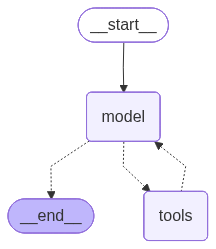

In [32]:
tools=[wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]

react_node = create_agent(llm,tools)
react_node

In [33]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

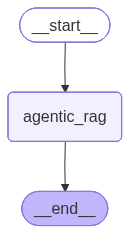

In [34]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph


In [39]:
query = "What do our internal research notes say about transformer variants, and what does ArXiv suggest recently?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

🧪 Searching ArXiv...
📚 Using tool: InternalResearchNotes

✅ Final Answer:
 Here's a summary of the findings from our internal research notes and recent results from ArXiv regarding transformer variants:

### Internal Research Notes
1. **EfficientFormer**
   - **Accuracy**: 92.4% on TinyImageNet
   - **Memory Usage**: 290MB (batch size = 16)
   - **Deployment**: Optimized for Raspberry Pi 4 using quantized int8 mode with no major accuracy drop.
   
2. **Longformer**
   - Evaluated on customer support logs (max tokens: 8192), with noticeable latency (>1.2s per query). Chunk-based hybrid attention may alleviate the delay.

3. **Reformer**
   - Issues: Bucket collisions, inconsistent loss spikes, and sparse gradient updates during LSH attention.
   - Solutions: Gradient clipping, warmup schedulers, and memory-efficient attention modules.
   
4. **TinyBERT**
   - Used for classification in support ticket prioritization achieving an 87% F1 score, but struggles with ambiguous classes.

5. **F